In [1]:

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os
import matplotlib.pyplot as plt
import numpy as np
import zipfile


class Generator(tf.keras.Model):
    def __init__(self, noise_dim):
        super(Generator, self).__init__()
        self.dense1 = layers.Dense(8 * 8 * 256, use_bias=False)
        self.batch_norm1 = layers.BatchNormalization()
        self.leaky_relu1 = layers.LeakyReLU()
        self.reshape = layers.Reshape((8, 8, 256))

        self.conv2d_transpose1 = layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False)
        self.batch_norm2 = layers.BatchNormalization()
        self.leaky_relu2 = layers.LeakyReLU()

        self.conv2d_transpose2 = layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False)
        self.batch_norm3 = layers.BatchNormalization()
        self.leaky_relu3 = layers.LeakyReLU()

        # Final layer to produce (64, 64, 3) image
        self.conv2d_transpose3 = layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')

    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.batch_norm1(x)
        x = self.leaky_relu1(x)
        x = self.reshape(x)
        x = self.conv2d_transpose1(x)
        x = self.batch_norm2(x)
        x = self.leaky_relu2(x)
        x = self.conv2d_transpose2(x)
        x = self.batch_norm3(x)
        x = self.leaky_relu3(x)
        x = self.conv2d_transpose3(x)
        return x


class Discriminator(tf.keras.Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        # Adjust input shape to (64, 64, 3)
        self.conv2d1 = layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=(64, 64, 3))
        self.leaky_relu1 = layers.LeakyReLU()
        self.dropout1 = layers.Dropout(0.3)

        self.conv2d2 = layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same')
        self.leaky_relu2 = layers.LeakyReLU()
        self.dropout2 = layers.Dropout(0.3)

        self.flatten = layers.Flatten()
        self.dense = layers.Dense(1)  # Output single value for real/fake classification

    def call(self, inputs):
        x = self.conv2d1(inputs)
        x = self.leaky_relu1(x)
        x = self.dropout1(x)
        x = self.conv2d2(x)
        x = self.leaky_relu2(x)
        x = self.dropout2(x)
        x = self.flatten(x)
        x = self.dense(x)
        return x


class GAN:
    def __init__(self, noise_dim):
        self.noise_dim = noise_dim
        self.generator = Generator(noise_dim)
        self.discriminator = Discriminator()
        self.cross_entropy = keras.losses.BinaryCrossentropy(from_logits=True)
        self.generator_optimizer = keras.optimizers.Adam(1e-4)
        self.discriminator_optimizer = keras.optimizers.Adam(1e-4)

    def generator_loss(self, fake_output):
        return self.cross_entropy(tf.ones_like(fake_output), fake_output)

    def discriminator_loss(self, real_output, fake_output):
        real_loss = self.cross_entropy(tf.ones_like(real_output), real_output)
        fake_loss = self.cross_entropy(tf.zeros_like(fake_output), fake_output)
        return real_loss + fake_loss
    def save(self, filepath):
        """Saves the GAN model by saving its generator and discriminator."""
        os.makedirs(filepath, exist_ok=True)
        self.generator.save(os.path.join(filepath, 'generator.keras')) # Added .h5 extension to the filename
        self.discriminator.save(os.path.join(filepath, 'discriminator.keras')) # Added .h5 extension to the filename

    def load(self, filepath):
        """Loads the GAN model by loading its generator and discriminator."""
        self.generator = keras.models.load_model(os.path.join(filepath, 'generator.keras')) # Added .h5 extension to the filename
        self.discriminator = keras.models.load_model(os.path.join(filepath, 'discriminator.keras')) # Added .h5 extension to the filename

In [2]:
from google.colab import drive
drive.mount('/content/drive')


# Chemin du fichier ZIP dans Google Drive
zip_path = '/content/drive/MyDrive/animefacedataset.zip'

# Répertoire de destination pour décompresser les fichiers
extract_path = '/content/anime_faces'

# Décompresser le fichier
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"Fichiers extraits dans : {extract_path}")


# Chemin vers le dossier des images extraites
image_dir = r'/content/anime_faces/images'

# Charger les images depuis le dossier


Mounted at /content/drive
Fichiers extraits dans : /content/anime_faces


63565


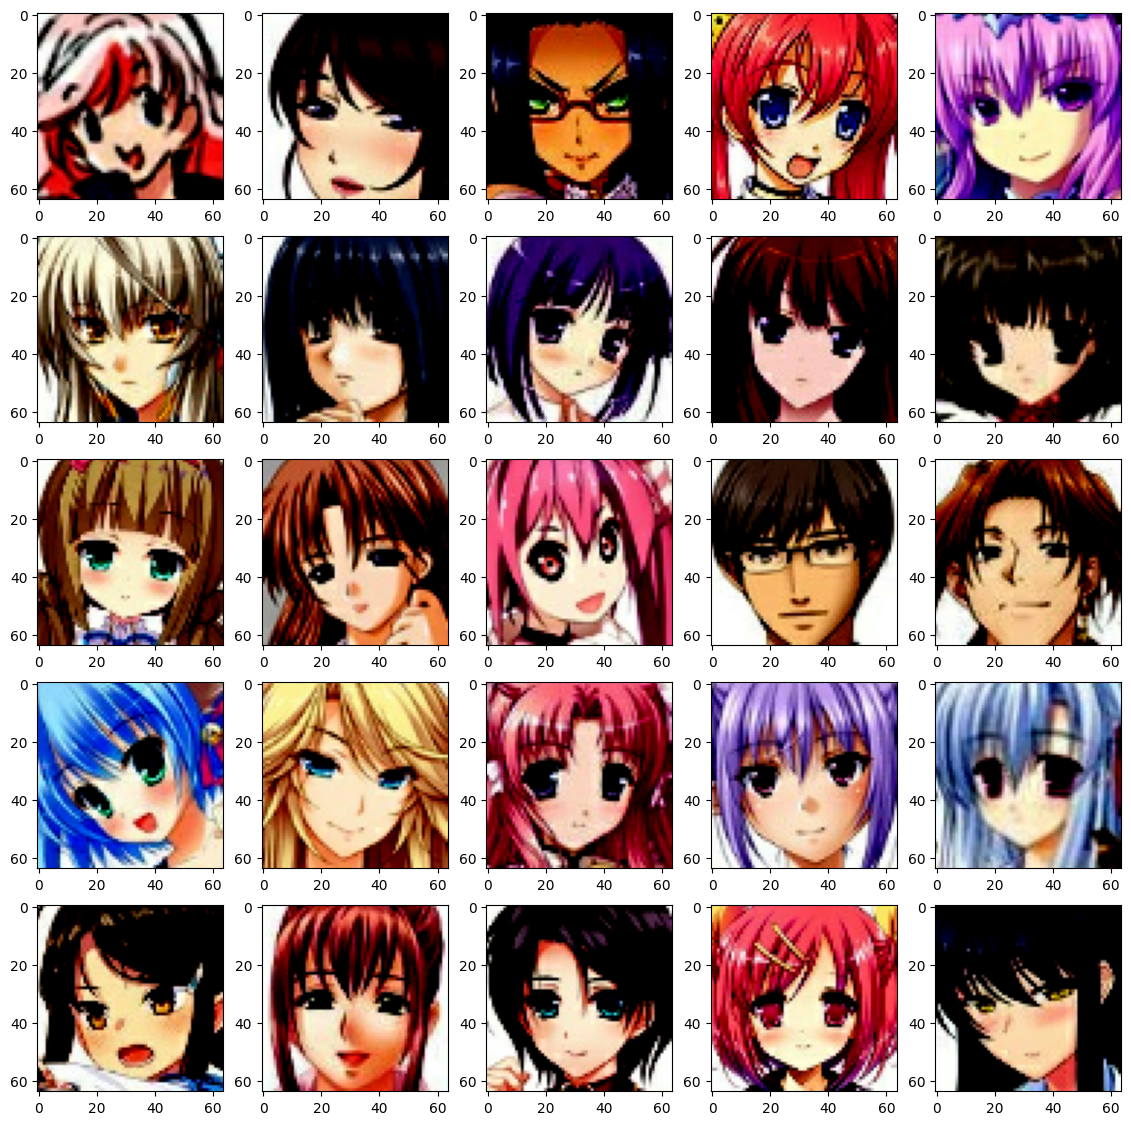

In [3]:
images = [os.path.join(image_dir, image) for image in os.listdir(image_dir)]

# Afficher les 6 premières images
images[:6]

image_size = 64

def preprocess(image):
    image = tf.io.read_file(image)
    image = tf.io.decode_jpeg(image)
    image = tf.image.resize(image, (64, 64))
    image = (image - 127.5) / 127.5  # Normalize to [-1, 1]
    return image

batch_size = 64

training_dataset = tf.data.Dataset.from_tensor_slices((images)) #Si images contient les chemins d'accès : alors le Dataset résultant contiendra seulement les chemins des fichiers

print(len(training_dataset))
training_dataset = training_dataset.map(preprocess)
training_dataset = training_dataset.shuffle(1000).batch(batch_size)

len(training_dataset)


# visualize some of them
fig, axes = plt.subplots(5,5, figsize = (14,14))
sample = training_dataset.unbatch().take(25)
sample = [image for image in sample]

idx = 0
for row in range(5):
    for column in range(5):
        axes[row, column].imshow(sample[idx])#imshow peut détecter que les valeurs des pixels sont entre 0 et 1 (au lieu de 0 et 255) et ajuste l'affichage pour montrer les images correctement
        idx+=1





In [4]:

noise_dim = 100
batch_size = 64
epochs = 50
latent_dim = 100 # define latent_dim
gan = GAN(noise_dim)


#@tf.function

# Ensure the output directory exists
output_dir = '/content/output'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Your existing train_step and train functions remain the same

def train_step(images,gan1):
    noise = tf.random.normal([batch_size, noise_dim])

    # Train discriminator
    with tf.GradientTape() as disc_tape:
        generated_images = gan1.generator(noise, training=True)
        real_output = gan1.discriminator(images, training=True)
        fake_output = gan1.discriminator(generated_images, training=True)
        disc_loss = gan1.discriminator_loss(real_output, fake_output)

    gradients_of_discriminator = disc_tape.gradient(disc_loss, gan1.discriminator.trainable_variables)
    gan1.discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, gan1.discriminator.trainable_variables))

    # Train generator
    with tf.GradientTape() as gen_tape:
        generated_images = gan1.generator(noise, training=True)
        fake_output = gan1.discriminator(generated_images, training=True)
        gen_loss = gan1.generator_loss(fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, gan1.generator.trainable_variables)
    gan1.generator_optimizer.apply_gradients(zip(gradients_of_generator, gan1.generator.trainable_variables))

    return disc_loss, gen_loss


# Utilisation de listes au lieu de np.array pour éviter l'erreur de .append()
disc_error = []
gen_error = []

def train(dataset, epochs, gan1):
    for epoch in range(epochs):
        disc_tot = 0.0  # Réinitialisation des accumulateurs à chaque époque
        gen_tot = 0.0

        for image_batch in dataset:
            disc_loss, gen_loss = train_step(image_batch, gan1)
            disc_tot += disc_loss.numpy()
            gen_tot += gen_loss.numpy()

        # Calcul de la moyenne des erreurs pour l'époque
        disc_mean = disc_tot / len(dataset)
        gen_mean = gen_tot / len(dataset)

        # Stockage des erreurs
        disc_error.append(disc_mean)
        gen_error.append(gen_mean)

        print(f'Epoch {epoch+1}, Gen Loss: {gen_mean}, Disc Loss: {disc_mean}')

        # Génération et sauvegarde d'images
        random_vector = tf.random.normal(shape=(25, latent_dim))
        generate_and_save_images(gan1.generator, epoch + 1, random_vector)


def generate_and_save_images(model, epoch, test_input, output_dir="output_images"):
    os.makedirs(output_dir, exist_ok=True)  # Création du dossier si inexistant
    predictions = model(test_input, training=False)

    for i in range(predictions.shape[0]):
        image = (predictions[i, :, :, 0] + 1) / 2  # Normalisation entre 0 et 1
        plt.imshow(image, cmap='gray')
        plt.axis('off')

        # Sauvegarde de chaque image individuellement
        image_path = os.path.join(output_dir, f'epoch_{epoch:04d}_image_{i+1:02d}.png')
        plt.savefig(image_path, bbox_inches='tight', pad_inches=0)
        plt.close()


# Call the training function



/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [5]:
train(training_dataset, epochs,gan)

Epoch 1, Gen Loss: 3.6151686164454917, Disc Loss: 0.3732655841859069
Epoch 2, Gen Loss: 3.860418240788957, Disc Loss: 0.3490611807156497
Epoch 3, Gen Loss: 3.4712862804142284, Disc Loss: 0.408889968525356
Epoch 4, Gen Loss: 3.0830564214669964, Disc Loss: 0.5187253813058798
Epoch 5, Gen Loss: 2.737788205295501, Disc Loss: 0.658168200350983
Epoch 6, Gen Loss: 2.305337879319546, Disc Loss: 0.7838452032334368
Epoch 7, Gen Loss: 2.155445173112919, Disc Loss: 0.9311225656532426
Epoch 8, Gen Loss: 1.971715298157103, Disc Loss: 1.0579850604116796
Epoch 9, Gen Loss: 1.8653162199726527, Disc Loss: 1.093990799182018
Epoch 10, Gen Loss: 1.727092433203634, Disc Loss: 1.1448225203894034
Epoch 11, Gen Loss: 1.5181659557210128, Disc Loss: 1.1622083241371082
Epoch 12, Gen Loss: 1.6297566437385451, Disc Loss: 1.1372637272600676
Epoch 13, Gen Loss: 1.6755089241733974, Disc Loss: 1.0598512050251605
Epoch 14, Gen Loss: 1.766738306288748, Disc Loss: 1.0198967582143288
Epoch 15, Gen Loss: 1.74707081656101, D

KeyboardInterrupt: 

In [ ]:
gan.save("/content/gan.model")

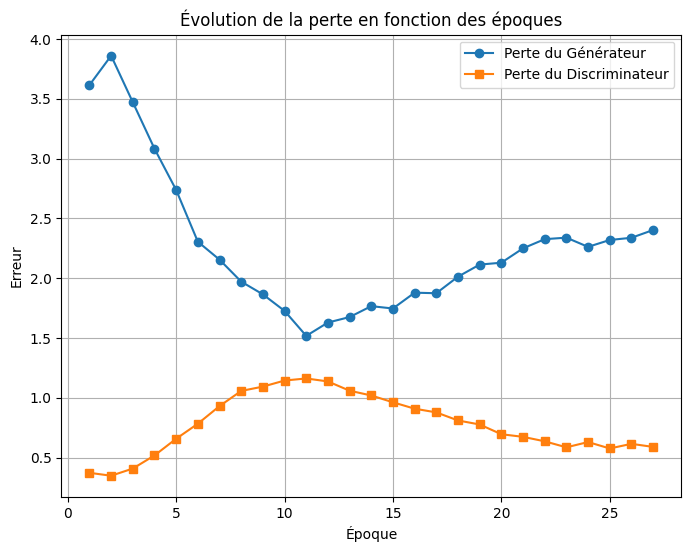

In [6]:
def plot_losses(gen_error, disc_error):
    epochs = range(1, len(gen_error) + 1)  # Création de la liste des époques

    plt.figure(figsize=(8, 6))
    plt.plot(epochs, gen_error, label="Perte du Générateur", marker='o', linestyle='-')
    plt.plot(epochs, disc_error, label="Perte du Discriminateur", marker='s', linestyle='-')

    plt.xlabel("Époque")
    plt.ylabel("Erreur")
    plt.title("Évolution de la perte en fonction des époques")
    plt.legend()
    plt.grid()
    plt.show()

# Exemple d'appel (une fois que tu as rempli disc_error et gen_error avec le training)
plot_losses(gen_error, disc_error)

In [7]:
import shutil
import os

source_folder = "/content/output_images"
destination_folder = "/content/drive/My Drive/output_images_colab_ANIME1"

# Créer le dossier de destination s'il n'existe pas
os.makedirs(destination_folder, exist_ok=True)

# Copier tous les fichiers
for file_name in os.listdir(source_folder):
    full_file_name = os.path.join(source_folder, file_name)
    if os.path.isfile(full_file_name):
        shutil.copy(full_file_name, destination_folder)

print("Copie terminée !")

Copie terminée !
